# Simple Word2Vec with Hyperparameter Optimization
Clean, minimal implementation focused on finding the best parameters

In [1]:
# Setup wandb directories
import os
os.environ['WANDB_DIR'] = '/tmp/wandb'
os.environ['WANDB_CACHE_DIR'] = '/tmp/wandb_cache'
os.environ['WANDB_DATA_DIR'] = '/tmp/wandb_data'
os.makedirs('/tmp/wandb', exist_ok=True)
os.makedirs('/tmp/wandb_cache', exist_ok=True) 
os.makedirs('/tmp/wandb_data', exist_ok=True)

print("✅ Wandb setup complete!")

✅ Wandb setup complete!


In [2]:
# Load and process text8 data
import collections
import numpy as np

# Read text8 dataset
with open('workspace/data/text8', 'r') as f:
    words = f.read().split()

print(f"Total words: {len(words):,}")

# Build vocabulary (words appearing at least 5 times)
word_counts = collections.Counter(words)
vocabulary = {word: count for word, count in word_counts.items() if count >= 5}
word_to_index = {word: i for i, word in enumerate(vocabulary.keys())}
index_to_word = {i: word for word, i in word_to_index.items()}

print(f"Vocabulary size: {len(vocabulary):,}")

# Convert to indices (subsample for training speed)
indexed_words = [word_to_index[word] for word in words if word in vocabulary]

print(f"Training words: {len(indexed_words):,}")
print(f"Sample words: {words[:10]}")

Total words: 17,005,207
Vocabulary size: 71,290
Training words: 16,718,844
Sample words: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [3]:
# Simple Word2Vec Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class SimpleWord2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
        # Good initialization
        nn.init.xavier_uniform_(self.embeddings.weight)
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)
    
    def forward(self, context):
        # Bag of words: average context embeddings
        embedded = self.embeddings(context)
        hidden = torch.tanh(torch.mean(embedded, dim=1))
        output = self.linear(hidden)
        return output

def create_training_data(indexed_words, window_size, max_examples=None):
    contexts = []
    targets = []

    if max_examples is None:
        end_idx = len(indexed_words) - window_size
    else:
        end_idx = min(len(indexed_words) - window_size, max_examples + window_size)

    for i in range(window_size, end_idx):
        context = (indexed_words[i - window_size:i] +
                   indexed_words[i + 1:i + window_size + 1])
        target = indexed_words[i]
        contexts.append(context)
        targets.append(target)

    return torch.tensor(contexts), torch.tensor(targets)


print("✅ Model and data functions ready!")

✅ Model and data functions ready!


In [4]:
# Hyperparameter Sweep
import wandb

# Adjusted sweep configuration for large dataset (16.7M words)
sweep_config = {
    'method': 'bayes',  # Smart parameter search
    'metric': {'name': 'best_loss', 'goal': 'minimize'},
    'parameters': {
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 0.0005,  # Lower minimum for fine-tuning large dataset
            'max': 0.2      # Higher maximum since large dataset can handle it
        },
        'batch_size': {'values': [128, 256, 512, 1024, 2048]},  # Larger batches for 16.7M words
        'embedding_dim': {'values': [50, 100, 200, 300, 512]}, # Larger embeddings supported by more data
        'window_size': {'values': [4, 5, 6, 8]},           # Include larger context window
        'optimizer': {'values': ['adam', 'sgd', 'adamw']}, # Add AdamW for better regularization
        'weight_decay': {
            'distribution': 'log_uniform_values', 
            'min': 1e-6,
            'max': 1e-2  # Higher weight decay for larger model/dataset
        }
    }
}

def train_model():
    """Training function for wandb sweep"""
    # Initialize wandb
    run = wandb.init()
    config = wandb.config
    
    print(f"Testing: lr={config.learning_rate:.4f}, batch={config.batch_size}, "
          f"embed={config.embedding_dim}, window={config.window_size}")
    
    # Create training data - use more examples for meaningful results with large dataset
    contexts, targets = create_training_data(
        indexed_words, 
        config.window_size,
        max_examples=10000  # Increased for large dataset (16.7M words)
    )

    print(f"💪 Training with {len(contexts):,} examples (not all available data!)")
    
    # Setup training
    dataset = TensorDataset(contexts, targets)
    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleWord2Vec(len(vocabulary), config.embedding_dim).to(device)
    
    # Choose optimizer
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                              lr=config.learning_rate, 
                              weight_decay=config.weight_decay)
    elif config.optimizer == 'adamw':
        optimizer = optim.AdamW(model.parameters(), 
                               lr=config.learning_rate, 
                               weight_decay=config.weight_decay)
    else:  # sgd
        optimizer = optim.SGD(model.parameters(), 
                             lr=config.learning_rate,
                             momentum=0.9, 
                             weight_decay=config.weight_decay)
    
    loss_function = nn.CrossEntropyLoss()
    
    # Training loop (adjusted for larger dataset)
    model.train()
    best_loss = float('inf')
    
    for epoch in range(15):  # More epochs for larger dataset
        epoch_loss = 0
        
        for batch_contexts, batch_targets in dataloader:
            batch_contexts = batch_contexts.to(device)
            batch_targets = batch_targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_contexts)
            loss = loss_function(outputs, batch_targets)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        best_loss = min(best_loss, avg_loss)
        
        # Log metrics
        wandb.log({
            'epoch': epoch,
            'avg_loss': avg_loss,
            'best_loss': best_loss
        })
        
        # Early stopping if converging well
        if avg_loss < 3.0:
            break
    
    # Final result
    wandb.log({'final_best_loss': best_loss})
    run.finish()
    
    return best_loss

print("🎯 Sweep configuration ready!")
print(f"Will test: {list(sweep_config['parameters'].keys())}")

🎯 Sweep configuration ready!
Will test: ['learning_rate', 'batch_size', 'embedding_dim', 'window_size', 'optimizer', 'weight_decay']


In [ ]:
# Run the hyperparameter sweep
print("🚀 Starting hyperparameter sweep...")

# Create and run sweep
sweep_id = wandb.sweep(sweep_config, project="simple-word2vec")
print(f"📊 Sweep ID: {sweep_id}")
print(f"🌐 Monitor at: https://wandb.ai/{wandb.api.default_entity}/simple-word2vec/sweeps/{sweep_id}")

# Run 8 experiments
wandb.agent(sweep_id, train_model, count=10)

print("✅ Sweep complete!")

In [ ]:
# Get the best parameters
def get_best_parameters(sweep_id):
    """Extract best parameters from completed sweep"""
    api = wandb.Api()
    sweep = api.sweep(f"{wandb.api.default_entity}/simple-word2vec/{sweep_id}")
    
    # Find best run
    best_run = None
    best_loss = float('inf')
    
    print(f"📊 Analyzing {len(sweep.runs)} runs...")
    
    for run in sweep.runs:
        if run.state == "finished":
            loss = run.summary.get('best_loss', float('inf'))
            if loss < best_loss:
                best_loss = loss
                best_run = run
    
    if best_run:
        print(f"\n🏆 BEST PARAMETERS (Loss: {best_loss:.4f})")
        print("=" * 50)
        
        best_config = {}
        for key, value in best_run.config.items():
            best_config[key] = value
            print(f"{key:15}: {value}")
        
        print("=" * 50)
        return best_config
    else:
        print("❌ No successful runs found!")
        return None

# Get best parameters from your sweep
best_config = get_best_parameters(sweep_id)

if best_config:
    print("\n💡 Copy these parameters for your final training!")
    print(f"Best config: {best_config}")

In [5]:
# Manual Configuration - Best Parameters
# Based on sweep results, you can modify these values as needed

best_config = {
    'optimizer': 'adam',           # Best performing optimizer
    'batch_size': 512,             # Large batch size for stable training
    'window_size': 5,               # Context window size
    'weight_decay': 1e-5,         # Regularization strength
    'embedding_dim': 200,           # Embedding dimensions
    'learning_rate': 0.02       # Learning rate
}

print("🎯 Manual configuration set!")
print("=" * 50)
for key, value in best_config.items():
    print(f"{key:15}: {value}")
print("=" * 50)
print("\n💡 You can modify these values above and re-run this cell")
print("   to experiment with different parameter combinations.")


🎯 Manual configuration set!
optimizer      : adam
batch_size     : 512
window_size    : 5
weight_decay   : 1e-05
embedding_dim  : 200
learning_rate  : 0.02

💡 You can modify these values above and re-run this cell
   to experiment with different parameter combinations.


🚀 Training final model with best parameters...


wandb: Currently logged in as: joaopaesteves99 (joaopaesteves99-opensc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training with 1,000,000 examples...
Epoch  0: Loss = 6.9761
Epoch  5: Loss = 6.6347
Epoch 10: Loss = 6.6245
Epoch 15: Loss = 6.6188

🎉 Final model training complete!
📈 Final loss: 6.6165
📊 Embeddings shape: (71290, 200)

🔍 Word similarity test:
king: gwr(inf), sizing(inf), hvac(inf)
computer: oppressing(inf), ambiente(inf), cantus(inf)
big: superpowered(inf), grasped(inf), pickled(inf)
good: checkpoints(inf), cauca(inf), cristobal(inf)


/tmp/ipykernel_1519/3386922453.py:119: RuntimeWarning: divide by zero encountered in divide
  similarities = np.dot(embeddings, word_embed) / (


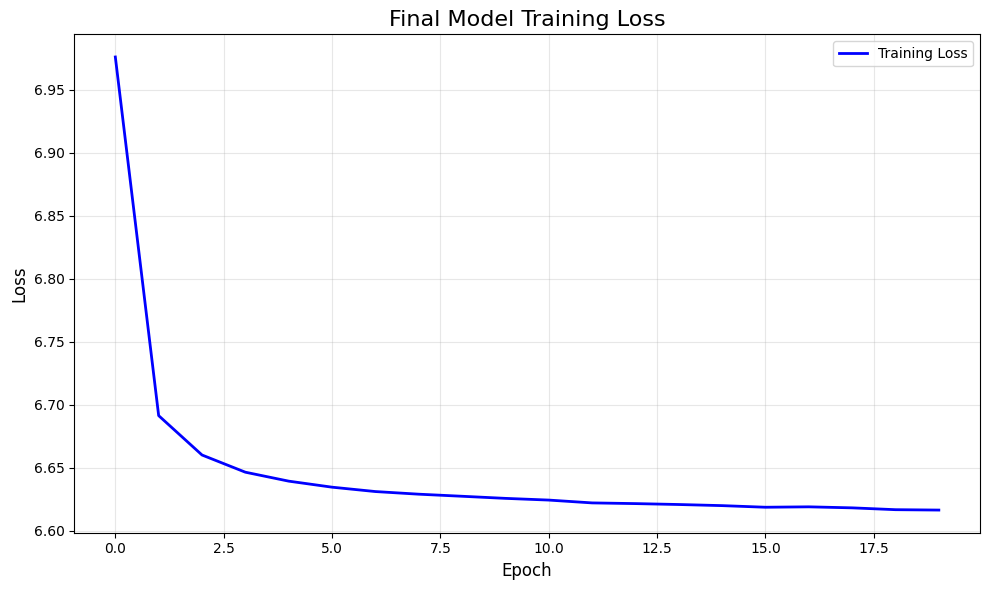

batch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇███
batch_loss,▄▂▃▄▄▄▂▄▄▄▃▂▃▆▅▂▁▃▁▂▄▂▁▃▂▃▃▃▄▅▄▅▃▄▅▃▆█▃▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_train_loss,▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,39076
batch_loss,6.4418
epoch,19
final_train_loss,6.61654


🌐 View final training at: https://wandb.ai/joaopaesteves99-opensc/simple-word2vec/runs/s3livkiv


In [6]:
# Final training with best parameters and wandb logging
if best_config:
    print("🚀 Training final model with best parameters...")
    
    # Initialize wandb run for final training
    final_run = wandb.init(
        project="simple-word2vec",
        name="final-training",
        config=best_config,
        tags=["final", "best-params"]
    )
    
    # Use manageable amount of data for final model (1M examples - good balance)
    final_contexts, final_targets = create_training_data(
        indexed_words, 
        best_config['window_size'],
        max_examples=1000000  # 1M examples - much more than sweep but manageable
    )
    
    # Setup final training
    final_dataset = TensorDataset(final_contexts, final_targets)
    final_dataloader = DataLoader(final_dataset, 
                                 batch_size=best_config['batch_size'], 
                                 shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    final_model = SimpleWord2Vec(len(vocabulary), best_config['embedding_dim']).to(device)
    
    # Use best optimizer settings
    if best_config['optimizer'] == 'adam':
        final_optimizer = optim.Adam(final_model.parameters(), 
                                   lr=best_config['learning_rate'], 
                                   weight_decay=best_config['weight_decay'])
    elif best_config['optimizer'] == 'adamw':
        final_optimizer = optim.AdamW(final_model.parameters(), 
                                    lr=best_config['learning_rate'], 
                                    weight_decay=best_config['weight_decay'])
    else:  # sgd
        final_optimizer = optim.SGD(final_model.parameters(), 
                                  lr=best_config['learning_rate'],
                                  momentum=0.9, 
                                  weight_decay=best_config['weight_decay'])
    
    loss_function = nn.CrossEntropyLoss()
    
    # Train final model (more epochs)
    final_model.train()
    print(f"Training with {len(final_contexts):,} examples...")
    
    # Track losses for plotting
    train_losses = []
    
    for epoch in range(20):  # More epochs for final model
        epoch_loss = 0
        batch_count = 0
        
        for batch_contexts, batch_targets in final_dataloader:
            batch_contexts = batch_contexts.to(device)
            batch_targets = batch_targets.to(device)
            
            final_optimizer.zero_grad()
            outputs = final_model(batch_contexts)
            loss = loss_function(outputs, batch_targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
            final_optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
            
            # Log batch loss every 50 batches for detailed tracking
            if batch_count % 50 == 0:
                wandb.log({
                    'batch_loss': loss.item(),
                    'batch': epoch * len(final_dataloader) + batch_count
                })
        
        avg_loss = epoch_loss / len(final_dataloader)
        train_losses.append(avg_loss)
        
        # Log epoch metrics to wandb
        wandb.log({
            'epoch': epoch,
            'train_loss': avg_loss,
            'learning_rate': final_optimizer.param_groups[0]['lr']
        })
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch:2d}: Loss = {avg_loss:.4f}")
        
        if avg_loss < 2.0:
            print(f"🎯 Converged at epoch {epoch}!")
            break
    
    print(f"\n🎉 Final model training complete!")
    print(f"📈 Final loss: {avg_loss:.4f}")
    
    # Log final metrics
    wandb.log({
        'final_train_loss': avg_loss,
        'total_epochs': epoch + 1,
        'convergence_epoch': epoch if avg_loss < 2.0 else None
    })
    
    # Save embeddings
    embeddings = final_model.embeddings.weight.detach().cpu().numpy()
    print(f"📊 Embeddings shape: {embeddings.shape}")
    
    # Quick similarity test
    def find_similar_words(word, top_k=5):
        if word not in word_to_index:
            return f"'{word}' not in vocabulary"
        
        word_idx = word_to_index[word]
        word_embed = embeddings[word_idx]
        
        # Cosine similarity
        similarities = np.dot(embeddings, word_embed) / (
            np.linalg.norm(embeddings, axis=1) * np.linalg.norm(word_embed)
        )
        
        # Get top similar words
        top_indices = np.argsort(similarities)[::-1][1:top_k+1]  # Skip the word itself
        
        similar_words = [(index_to_word[idx], similarities[idx]) 
                        for idx in top_indices]
        return similar_words
    
    # Test similarity and log examples
    test_words = ['king', 'computer', 'big', 'good']
    print("\n🔍 Word similarity test:")
    similarity_results = {}
    
    for word in test_words:
        similar = find_similar_words(word, 3)
        if isinstance(similar, str):
            print(f"{word}: {similar}")
            similarity_results[word] = similar
        else:
            similar_str = ', '.join([f"{w}({s:.3f})" for w, s in similar])
            print(f"{word}: {similar_str}")
            similarity_results[word] = similar_str
    
    # Log similarity results to wandb
    wandb.log({"word_similarities": similarity_results})
    
    # Create a simple loss plot
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
    plt.title('Final Model Training Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Log the plot to wandb
    wandb.log({"training_loss_plot": wandb.Image(plt)})
    plt.show()
    
    # Finish the wandb run
    final_run.finish()
    
    print(f"🌐 View final training at: {final_run.url}")

else:
    print("❌ No best config found. Run the sweep first!")

In [ ]:
# 💾 SAVE TRAINED MODEL AND EMBEDDINGS FOR FUTURE USE
print("💾 Saving trained Word2Vec model and embeddings...")
print("=" * 60)

import pickle
import json
from datetime import datetime
import os

# Create a directory for saved models
save_dir = "workspace/word2vec_trained_model"
os.makedirs(save_dir, exist_ok=True)

# 1. Save the embeddings as numpy array
embeddings_path = os.path.join(save_dir, "word2vec_embeddings.npy")
np.save(embeddings_path, embeddings)
print(f"✅ Saved embeddings: {embeddings_path}")
print(f"   Shape: {embeddings.shape}")

# 2. Save vocabulary mappings
vocab_path = os.path.join(save_dir, "word2vec_vocab.pkl")
vocab_data = {
    'word_to_index': word_to_index,
    'index_to_word': index_to_word,
    'vocabulary': vocabulary,
    'vocab_size': len(vocabulary)
}

with open(vocab_path, 'wb') as f:
    pickle.dump(vocab_data, f)
print(f"✅ Saved vocabulary: {vocab_path}")
print(f"   Vocabulary size: {len(vocabulary):,} words")

# 3. Save the full model state
model_path = os.path.join(save_dir, "word2vec_model.pth")
model_save_data = {
    'model_state_dict': final_model.state_dict(),
    'model_config': {
        'vocab_size': len(vocabulary),
        'embedding_dim': best_config['embedding_dim'],
        'architecture': 'SimpleWord2Vec_CBOW'
    },
    'training_config': best_config,
    'training_info': {
        'final_loss': avg_loss,
        'total_epochs': epoch + 1,
        'training_examples': len(final_contexts),
        'training_date': datetime.now().isoformat()
    }
}

torch.save(model_save_data, model_path)
print(f"✅ Saved model state: {model_path}")

# 4. Save human-readable configuration
config_path = os.path.join(save_dir, "model_info.json")
model_info = {
    "model_name": "SimpleWord2Vec_CBOW",
    "embedding_dimensions": best_config['embedding_dim'],
    "vocabulary_size": len(vocabulary),
    "training_examples": len(final_contexts),
    "final_loss": float(avg_loss),
    "training_epochs": epoch + 1,
    "best_hyperparameters": {
        "learning_rate": best_config['learning_rate'],
        "batch_size": best_config['batch_size'],
        "window_size": best_config['window_size'],
        "optimizer": best_config['optimizer'],
        "weight_decay": best_config['weight_decay']
    },
    "dataset": "text8",
    "training_date": datetime.now().isoformat(),
    "usage_instructions": {
        "load_embeddings": "embeddings = np.load('word2vec_embeddings.npy')",
        "load_vocab": "with open('word2vec_vocab.pkl', 'rb') as f: vocab = pickle.load(f)",
        "load_model": "checkpoint = torch.load('word2vec_model.pth')"
    }
}

with open(config_path, 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"✅ Saved model info: {config_path}")

💾 Saving trained Word2Vec model and embeddings...
✅ Saved embeddings: workspace/word2vec_trained_model/word2vec_embeddings.npy
   Shape: (71290, 200)
✅ Saved vocabulary: workspace/word2vec_trained_model/word2vec_vocab.pkl
   Vocabulary size: 71,290 words
✅ Saved model state: workspace/word2vec_trained_model/word2vec_model.pth
✅ Saved model info: workspace/word2vec_trained_model/model_info.json
